In [19]:
import json
from os import listdir
from os.path import isfile, join

files = [f for f in listdir('/home/max/Desktop/pySCIL-MetaTaggerTrain/dialogues') if isfile(join('/home/max/Desktop/pySCIL-MetaTaggerTrain/dialogues', f))]

In [20]:
turnlens = []
for f in files:
    with open('dialogues/'+f) as handle:
        data = json.load(handle)
        turnlens.append(len(data['turns']))

print(turnlens)
print('Average turns:', sum(turnlens)/(len(turnlens)))
print('Total turns:', sum(turnlens))

[804, 434, 547, 947, 451, 480, 943, 595, 283, 883, 595, 946, 679]
Average turns: 660.5384615384615
Total turns: 8587


In [21]:
# Combine all turns into one long list
allTurns = []
for f in files:
    with open('dialogues/'+f) as handle:
        data = json.load(handle)
        for turn in data['turns']:
            allTurns.append(turn)

In [22]:
# Create docs
docs = [[turn['text'],turn['dialog_act'].split(':')[0].lower()] for turn in allTurns if turn['dialog_act'] != '']
print(len(docs))
print(852+1265+299+5418)

7834
7834


In [23]:
# Create data frame
import pandas as pd

df = pd.DataFrame(docs, columns = ['Text','Meta'])
df['label'] = df['Meta'].factorize()[0]
labels_df = df[['Meta','label']].drop_duplicates().sort_values('label')
labels_to_id = dict(labels_df.values)
id_to_labels = dict(labels_df[['label','Meta']].values)
df.head()

,Text,Meta,label
0,thanks .,comm-mgmt,0
1,"a , and meg has been ( ? ? ? ) to be our leade...",prcs-mgmt,1
2,do you have extra pens ?,task,2
3,these do n't work .,task,2
4,yeah . no .,task,2


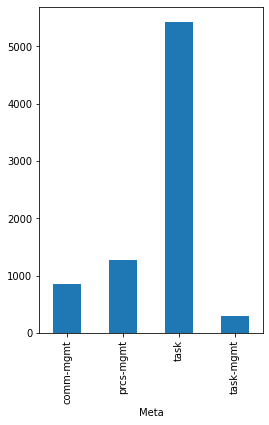

In [24]:
# get chart of imbalances
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,6))
df.groupby('Meta').Text.count().plot.bar(ylim=0)
plt.show()

In [33]:
# Vectorize each sentence using sklearn TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# setting up counter vectorizer settings
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, norm='l2', min_df=2, ngram_range=(1,2))

# applying the vectorizer
features = tfidf_vectorizer.fit_transform(df.Text).toarray()
labels = df.label
features.shape

(7834, 12666)

In [34]:
# Find the terms most correlated with each meta tag
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Meta, label in sorted(labels_to_id.items()):
    features_chi2 = chi2(features, labels == label)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Meta))
    print(">>Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print(">>Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'comm-mgmt':
>>Most correlated unigrams:
. lol
. hi
>>Most correlated bigrams:
. thank you
. good night
# 'prcs-mgmt':
>>Most correlated unigrams:
. we
. prize
>>Most correlated bigrams:
. peace prize
. do we
# 'task':
>>Most correlated unigrams:
. yeah
. hi
>>Most correlated bigrams:
. thank you
. good night
# 'task-mgmt':
>>Most correlated unigrams:
. carla
. richard
>>Most correlated bigrams:
. so carla
. for richard


In [35]:
# Try on Naive Bayes
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Meta'], random_state=42)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

X_test_tfidf = tfidf_vectorizer.transform(X_test)
predicted = clf.predict(X_test_tfidf)
np.mean(predicted == y_test)

0.7182235834609495

In [47]:
#test models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200,max_depth=3,random_state=42),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=42),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV*len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_tfidf, y_train, scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

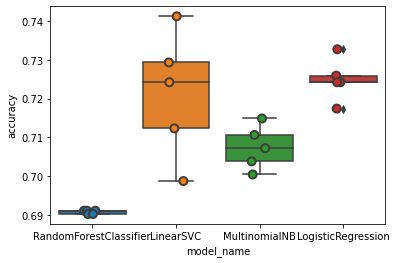

In [48]:
# Plot the results
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name',y='accuracy', data=cv_df, size=8, jitter=True, edgecolor='gray',linewidth=2)
plt.show()

In [49]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.721191
LogisticRegression        0.724936
MultinomialNB             0.707404
RandomForestClassifier    0.690723
Name: accuracy, dtype: float64

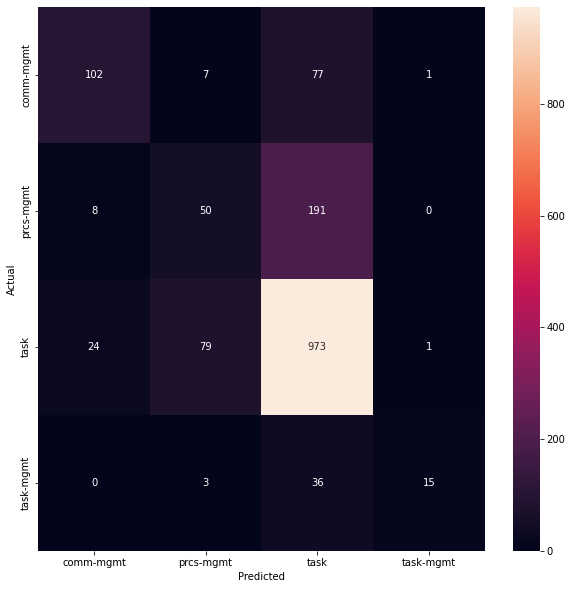

In [51]:
# Continue evaluation with Linear SVC
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_df.Meta.values, yticklabels=labels_df.Meta.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [53]:
# print classification report for each class
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Meta'].unique()))

              precision    recall  f1-score   support

   comm-mgmt       0.76      0.55      0.64       187
   prcs-mgmt       0.36      0.20      0.26       249
        task       0.76      0.90      0.83      1077
   task-mgmt       0.88      0.28      0.42        54

    accuracy                           0.73      1567
   macro avg       0.69      0.48      0.54      1567
weighted avg       0.70      0.73      0.70      1567

